## Pytorch Implementation of [Reinforcement Learning for Solving](https://arxiv.org/pdf/1802.04240.pdf)

Thanks for [pytorch-drl4vrp](https://github.com/mveres01/pytorch-drl4vrp). 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch.distributions import Categorical, Multinomial

%matplotlib inline

In [2]:
from IPython.display import clear_output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_CUDA = False

### Tour length (Reward function)

In [3]:
# define tour length function as reward
def tour_length(pi, use_cuda = USE_CUDA):
    '''
    calculate the total length of the tour
    Args:
    pi (list): length is sequence length, 
                the element shape is (batch_size, point_size)
    Return:
    tour_len (tensor): (batch_size, 1)
    '''
    
    n = len(pi)
    batch_size = pi[0].size(0)
    tour_len = Variable(torch.zeros(batch_size))
    
    if use_cuda:
        tour_len = tour_len.cuda()
        
    for i in range(n-1):
        tour_len += torch.norm(pi[i+1] - pi[i], p = 2, dim = 1)
    tour_len += torch.norm(pi[n-1] - pi[0], p = 2, dim = 1)
    return tour_len

### Embedding

In [4]:
class Embedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda = USE_CUDA):
        super().__init__()
        self.embedding_size = embedding_size
        
        self.embedding = nn.Conv1d(input_size, embedding_size, 1)
        
    def forward(self, inputs):
        '''
        Args:
        inputs (batch_size, input_size, seq_len)
        
        Return:
        embedded (batch_size, embedding_size, seq_len)
        '''
        embedded = self.embedding(inputs)
        
        return embedded

### Attention

In [148]:
class Attention(nn.Module):
    
    def __init__(self, hidden_size, use_cuda = USE_CUDA):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Attention trainable parameters
        Wa = torch.zeros((1, hidden_size, 3 * hidden_size))
        va = torch.zeros(1, 1, hidden_size).float() 
        va = nn.Parameter(va, requires_grad=True)
        Wa = nn.Parameter(Wa, requires_grad = True)
        
        if use_cuda:
            va = va.cuda()
            Wa = Wa.cuda()
        self.Wa = Wa
        self.va = va
        
        # nolinear
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
    
    def forward(self, static, dynamic, decoder_out):
        '''
        Args:
        - static (batch_size, embedding_size, seq_len)
        - dynamic (batch_size, embedding_size, seq_len)
        - decoder_out (batch_size,  hidden_size)
        Note that: embedding_size = hidden_size
        '''
        batch_size = static.size(0)
        seq_len = static.size(2)
        expand_ht = decoder_out.unsqueeze(2).expand(batch_size, -1, seq_len)
        expand_va = self.va.expand(batch_size, 1, hidden_size)
        expand_Wa = self.Wa.expand(batch_size, hidden_size, -1)
        
        concat_xh = torch.cat([static, dynamic, expand_ht], dim = 1) # (batch_size, hidden_size * 3, seq_len)
        
        u = torch.bmm(expand_va, \
                      self.tanh(torch.bmm(expand_Wa, concat_xh))).squeeze(1) # (batch_size, seq_len)
        
        a = self.softmax(u)
       
        return a

In [149]:
batch_size = 128
hidden_size = 128
seq_len = 20
s, d, ht = torch.randn(batch_size, hidden_size, seq_len), \
        torch.randn(batch_size, hidden_size, seq_len), torch.randn(batch_size,  hidden_size)
a_layer = Attention(hidden_size)
a_layer(s, d, ht).size()

D:\Application\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([128, 20])

### Mask Scheme
At this time, we do not consider split delivery.

In [20]:
def mask_logit(logit, dynamic, prev_idx):
    '''
    mask log probabilities
    Note that the first element in sequence length is depot location
    Args:
    logit (tensor): (batch_size, seq_len)
    dymaic (tensor): dynamic features (batch_size, 2, seq_len)
    '''
    
    # first index should be depot
    logit = logit.clone()
    if prev_idx is None:
        logit[:, 0] = 1
        logit[:, 1:] = 0
        return logit

    load, demands = dynamic[:, 0, :], dynamic[:, 1, :]
    batch_size, seq_len = logit.size()
    # mask zero demands
    zero_demands = (demands == 0).data.byte()
    zero_demands[[b for b in range(batch_size)], 0] = 0 # don't mask depot
    logit[zero_demands] = 0
    
    # zero load
    zero_load = (load == 0).data.byte()
    logit[zero_load] = 0
    logit[:, 0] = 1
        
    # mask greater than load (not allowed split delivery)
    greater_load = (demands > load).data.byte()
    logit[greater_load] = 0
    
    # mask depot if load is full
    full_load = (prev_idx == 0).data.byte()
    logit[full_load, 0] = 0
    
    # all zeros
    all_zeros = (logit.sum(dim = 1) == 0).data.byte()
    logit[all_zeros, 0] = 1
    
    return logit

In [21]:
logit = torch.randn(128, 20)
load = torch.ones(128, 1, 20) * 10
demands = torch.randint(1, 20, (128, 1, 20))
dynamic = torch.cat([load, demands], dim = 1)
prev_idx = torch.randint(0, 20, (128,)).long()
mask_logit(logit, dynamic, prev_idx).size()

torch.Size([128, 20])

### Update states

In [116]:
def update(prev_idx, dynamic, capacity):
    '''
    update states
    
    Args:
    prev_idx (tensor or None): (batch_size,)
    dynamic (tensor): (batch_size, 2, seq_len)
    '''
    loads, demands = dynamic[:, 0, :], dynamic[:, 1, :]
    loads, demands = loads.clone(), demands.clone()
    if prev_idx is None:
        return dynamic
    
    batch_size, seq_len = demands.size()
    finish_demands = deepcopy(demands[[b for b in range(batch_size)], prev_idx.data])
    
    load_copy = loads.clone()
    
    demands[[b for b in range(batch_size)], prev_idx.data] = torch.max(torch.zeros_like(finish_demands), \
                  finish_demands - loads[:, 0])
    
    prev_load = deepcopy(loads[:, 0])
    new_loads = torch.max(torch.zeros_like(prev_load), prev_load - finish_demands)
    new_loads[(prev_idx == 0).data] = capacity
    
    demands = demands.unsqueeze(1)
    new_loads = new_loads.unsqueeze(1).expand(batch_size, seq_len).unsqueeze(1)
    new_dynamic = torch.cat([new_loads, demands], dim = 1)
    
    return new_dynamic

In [117]:
load = torch.ones(128, 1, 20) * 10
demands = torch.randint(1, 20, (128, 1, 20))
dynamic = torch.cat([load, demands], dim = 1)
prev_idx = torch.randint(0, 20, (128,)).long()
batch_size = 128
result = update(prev_idx, dynamic, 10)
new_load = result[:, 0, :]
demands = result[:, 1, :]
print(new_load[:10])
print(demands[:10])

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
        [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
          2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

### Modified Pointer Network

In [152]:
class PointerNet(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, seq_len, capacity, decoder_type = "sample", use_cuda = USE_CUDA):
        
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.decoder_type = decoder_type
        self.capacity = capacity
        
        self.decoder = nn.LSTM(embedding_size, hidden_size, num_layers = 1, 
                               dropout = 0.1, batch_first = True) # (batch_size, seq_len, hidden_size)
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(p = 0.1)
        
        self.static_embedding = Embedding(2, embedding_size)
        self.dynamic_embedding = Embedding(2, embedding_size)
        self.softmax = nn.Softmax()
        self.tanh = nn.Tanh()
        
        ## attention second step trainable parameters
        vc = torch.zeros(1, 1, hidden_size).float() 
        vc = nn.Parameter(vc, requires_grad=True)
        Wc = torch.zeros((1, hidden_size, 4 * hidden_size))
        Wc = nn.Parameter(Wc, requires_grad = True)
        
        if use_cuda:
            vc = vc.cuda()
            Wc = Wc.cuda()
        
        self.Wc = Wc
        self.vc = vc
        
        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)
        
        self.use_cuda = use_cuda
        
        decoder_input0 = torch.zeros((1, hidden_size, 1), requires_grad = True)
        
        if use_cuda:
            decoder_input0 = decoder_input0.cuda()
        self.decoder_input0 = decoder_input0
    
    def forward(self, static, dynamic):
        '''
        Args:
        static: static features (batch_size, 2, seq_len)
        dynamic: dynamic features (batch_size, 2, seq_len)
        Return:
        
        '''
        batch_size = static.size(0)
        seq_len = static.size(2)
        
        dynamic_copy = deepcopy(dynamic)
        embed_s = self.static_embedding(static) # (batch_size, hidden_size, seq_len)
        embed_d = self.dynamic_embedding(dynamic) # (batch_size, hidden_size, seq_len)
        
        ht, ct = None, None
        max_step = seq_len
        
        if self.use_cuda:
            ht = ht.cuda()
            ct = ct.cuda()
        
        decoder_input = self.decoder_input0.permute(0, 2, 1).expand(batch_size, 1, -1)
        index_list = []
        prob_list = []
        prev_idx = None
        count = 0
        for _ in range(max_step):
            if ht is None and ct is None:
                decoder_out, (ht, ct) = self.decoder(decoder_input)
            else:
                decoder_out, (ht, ct) = self.decoder(decoder_input, (ht, ct))
            decoder_out = decoder_out.squeeze(1)
            try:
                logit = self.attention(embed_s, embed_d, decoder_out) # (batch_size, seq_len)
            except:
                print(embed_s.size())
                print(embed_d.size())
                print(decoder_out.size())
                raise
            
            # attention second step
            x = torch.cat([embed_s, embed_d], dim = 1) # (batch_size, hidden_size *2, seq_len)
            context = torch.bmm(logit.unsqueeze(1), x.permute(0, 2, 1)) # (batch_size, 1, hidden_size * 2)
            context = context.permute(0, 2, 1).expand(batch_size, -1, self.seq_len)
            
            Wc = self.Wc.expand(batch_size, hidden_size, -1)
            vc = self.vc.expand(batch_size, 1, hidden_size)
            probs = torch.bmm(vc, self.tanh(torch.bmm(Wc, torch.cat([context, x], dim = 1)))).squeeze(1)
            
            probs = self.softmax(probs)
            probs = mask_logit(probs, dynamic, prev_idx)
            
            prob_list.append(probs)
            
            if self.decoder_type == "sample":
                try:
                    prob = Categorical(probs)
                    prev_idx = prob.sample().long()
                except:
                    print(prob)
                
            elif self.decoder_type == "greedy":
                prev_idx = torch.argmax(probs, dim = 1).long()
            
            # if return depot, refill and update dynamic elements
            dynamic = update(prev_idx, dynamic, self.capacity)   
#             dynamic = torch.Tensor(dynamic.data, device = device, requires_grad = True)
            if self.use_cuda:
                dynamic = dynamic.cuda()
                
            embed_d = self.dynamic_embedding(dynamic)
            
            decoder_input = embed_s[[b for b in range(batch_size)], \
                                    :, prev_idx.data].unsqueeze(1)
            
            index_list.append(prev_idx)
            
#             print(dynamic[:, 1, :].sum())
            if dynamic[:, 1, :].sum() == 0:
                break
            count += 1
        
        dynamic = dynamic_copy
            
        # get pi and log prob
        pi = []
        probs = []
        for i, index in enumerate(index_list):
            pi_ = static[[j for j in range(batch_size)], :, index.data]
            pi.append(pi_)
            prob_ = prob_list[i]
            prob_ = prob_[[j for j in range(batch_size)], index.data]
            probs.append(prob_)

        L = tour_length(pi)
        log_probs = 0
        for prob in probs:
            log_prob = torch.log(prob)
            log_probs += log_prob
            
        return index_list, prob_list, log_probs, L, pi, embed_s

In [153]:
capacity = 30
load = torch.ones(128,1, 20) * capacity
demands = torch.randint(1, 20, (128, 1, 20))
demands[:, :, 0] = 0
d = torch.cat([load, demands], dim = 1)
s = torch.randn(128, 2, 20)

net = PointerNet(128, 128, 20, capacity)
index_list, prob_list, log_probs, L, pi, _ = net(s, d)
print("Number of points: ", len(index_list))
print("size: ", index_list[0].size())

D:\Application\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
D:\Application\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Application\Anaconda3\lib\site-packages\ipykernel\__main__.py:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Number of points:  23
size:  torch.Size([128])


### Critic Network

In [63]:
class Critic(nn.Module):
    
    def __init__(self, hidden_size):
        super().__init__()
        self.decoder = nn.Sequential(
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))
    def forward(self, embed_s, prob_list, index_list):
        '''
        Args:
        embed_s (batch_size, hidden_size, seq_len)
        prob_list (list): with element (batch_size, seq_len)
        index_list (list): with element (batch_size, 1)
        '''
        
        # compute weighted sum
        batch_size = embed_s.size(0)
        hidden_size = embed_s.size(1)
        weighted_sum = torch.zeros(batch_size, hidden_size, 1)
        for i, index in enumerate(index_list):
            prob = prob_list[i]
            weighted_sum += torch.bmm(embed_s[[b for b in range(batch_size)], :, index.data].unsqueeze(2) \
                    , prob[[b for b in range(batch_size)], index.data].unsqueeze(1).unsqueeze(2))
        
        output = self.decoder(weighted_sum.squeeze(2))
        return output

In [154]:
class Model(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, seq_len, capacity, decoder_type = "sample"):
        super().__init__()
        self.actor = PointerNet(embedding_size, hidden_size, seq_len, capacity, decoder_type)
        self.critic = Critic(hidden_size)
        self.seq_len = seq_len
    
    def forward(self, static, dynamic):
        index_list, prob_list, log_probs, L, pi, embed_s = self.actor(static, dynamic)
        V = self.critic(embed_s, prob_list, index_list)
        return index_list, prob_list, log_probs, L, pi, V

### Train

In [155]:
# parameters
batch_size = 128
embedding_size = 128
hidden_size = 128
lr = 1e-4
vrp_num = 10
CAPACITY = 20
beta = 0.9

In [156]:
def collect_data(data_size, vrp_num, capacity):
    '''
    collect train and test data
    Args:
    data_size (int): how much data needed
    vrp_num (int): how many customers
    capacity (int): the capacity of vehicle
    '''
    data = []
    for i in range(data_size):
        points = np.random.uniform(0, 1, (1, 2, vrp_num))
        demands = np.random.choice(list(range(1, 10)), (1, 1, vrp_num))
        demands[:, :, 0] = 0 # the demand of depot is 0
        x = np.concatenate([points, demands], axis = 1)
        x = torch.from_numpy(x).float()
        data.append(x)
    return data
train_data = collect_data(1000000, vrp_num, CAPACITY)
test_data = collect_data(1000, vrp_num, CAPACITY)

In [157]:
# training
class Train(object):
    
    def __init__(self, model, train_set, validation_set, batch_size = 128, max_grad_norm = 2., lr = 1e-4, update_steps = 5000):
        self.model = model
        self.train_set = train_set
        self.validation_set = validation_set
        self.batch_size = batch_size
        self.max_grad_norm = max_grad_norm
        self.optimizer_all = Adam(list(model.critic.parameters()) + list(model.actor.parameters()), lr = lr)
        self.optimizer_pointer = Adam(model.actor.parameters(), lr = lr)
        self.lr_scheduler_pointer = lr_scheduler.MultiStepLR(self.optimizer_pointer, \
                                                     list(range(update_steps, update_steps * 1000, update_steps)), gamma=0.96)
        self.lr_scheduler_all = lr_scheduler.MultiStepLR(self.optimizer_all, \
                                                     list(range(update_steps, update_steps * 1000, update_steps)), gamma=0.96)
        self.mse_loss = nn.MSELoss()
        self.input_dim = 3 # points dimension
        
        self.train_rewards = []
        self.val_rewards = []
    
    def train_and_validation(self, n_epoch, training_steps, use_critic = True):
        moving_average = 0
        for epoch in range(n_epoch):
            for step in range(training_steps):
                training_set = random.sample(self.train_set, self.batch_size)
                training_set = Variable(torch.cat(training_set).view(self.batch_size, self.input_dim, -1))
                
                static = training_set[:, :2, :]
                d = training_set[:, 2, :].unsqueeze(1)
                load = torch.ones(d.size()) * CAPACITY
                dynamic = torch.cat([load, d], dim = 1)
                index_list, prob_list, log_probs, L, pi, V = self.model(static, dynamic)
                
                log_probs = log_probs.view(-1)
                log_probs[(log_probs < -1000).detach()] = 0.
                
                if not use_critic:
                    if step == 0:
                        moving_average = L.mean()
                    else:
                        moving_average = (moving_average * beta) + ((1. - beta) * L.mean())

                    advantage = L - moving_average             
                    actor_loss = (advantage * log_probs).mean()
                    
                                    
                    self.optimizer_pointer.zero_grad()
                    actor_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.actor.parameters(), self.max_grad_norm, norm_type=2)
                    self.optimizer_pointer.step()
                    self.lr_scheduler_pointer.step()
                    moving_average = moving_average.detach()
                         
                else:
                    critic_loss = self.mse_loss(V.view(-1), L)
                    advantage = L - V.view(-1)
                    actor_loss = (advantage * log_probs).mean()
                    loss = actor_loss + critic_loss
                    self.optimizer_all.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(list(self.model.critic.parameters()) + \
                                                   list(self.model.actor.parameters()), self.max_grad_norm, norm_type=2)
#                     torch.nn.utils.clip_grad_norm_(, self.max_grad_norm, norm_type=2)
                    self.optimizer_all.step()
                    self.lr_scheduler_all.step()

                self.train_rewards.append(L.mean().data[0])
                
                if step % 10 == 0:
                    self.plot(epoch)
                if step % 100 == 0:
                    val_set = Variable(torch.cat(self.validation_set).view(len(self.validation_set), self.input_dim, -1))
                    static = val_set[:, :2, :]
                    d = val_set[:, 2, :].unsqueeze(1)
                    load = torch.ones(d.size()) * CAPACITY
                    dynamic = torch.cat([load, d], dim = 1)
                    self.model.actor.decoder_type = "greedy"
                    index_list, prob_list, log_probs, L, pi, _ = self.model(static, dynamic)
                    self.val_rewards.append(L.mean().data[0])  
                    self.model.actor.decoder_type = "sample"
                    
                # model save
                if step % 1000 == 0:
                    if use_critic:
                        torch.save(self.model, os.path.join(os.getcwd(), \
                                                            'model_vrp{}_critic.pt'.format(self.model.seq_len)))
                    else:
                        torch.save(self.model, os.path.join(os.getcwd(), \
                                                            'model_vrp{}_mvg_avg.pt'.format(self.model.seq_len)))
    
    def plot(self, epoch):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('train tour length: epoch %s reward %s' % (epoch, self.train_rewards[-1] if len(self.train_rewards) else 'collecting'))
        plt.plot(self.train_rewards)
        plt.grid()
        plt.subplot(132)
        plt.title('val tour length: epoch %s reward %s' % (epoch, self.val_rewards[-1] if len(self.val_rewards) else 'collecting'))
        plt.plot(self.val_rewards)
        plt.grid()
        plt.show() 

In [158]:
model = Model(embedding_size, hidden_size, vrp_num, capacity)
vrp20_train = Train(model, train_data, test_data)

D:\Application\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


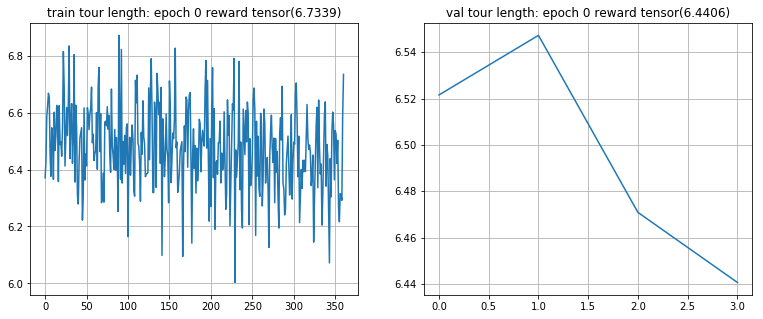

KeyboardInterrupt: 

In [159]:
vrp20_train.train_and_validation(6, 10000, False)

In [33]:
# check
val_set = Variable(torch.cat(test_data).view(len(test_data), 3, -1))
s = val_set[35, :2, :].unsqueeze(0)
d = val_set[35, 2, :].unsqueeze(0).unsqueeze(1)
print("before demands: ", d.size())
print("sum of demands: ", torch.sum(d))
load = torch.ones(1) * CAPACITY
index_list, prob_list, log_probs, L, pi, _ = vrp20_train.model((s, d, load))
print("Tour length:  ", L)
print("index list: ", index_list)
print("demands: ", d)
print("Policy: ", pi)

before demands:  torch.Size([1, 1, 20])
sum of demands:  tensor(63.)
Tour length:   tensor([9.9924])
index list:  [tensor([0]), tensor([5]), tensor([19]), tensor([10]), tensor([16]), tensor([12]), tensor([18]), tensor([17]), tensor([0]), tensor([11]), tensor([14]), tensor([2]), tensor([9]), tensor([1]), tensor([15]), tensor([4]), tensor([7]), tensor([6]), tensor([0]), tensor([8]), tensor([13]), tensor([3]), tensor([0])]
demands:  tensor([[[0., 3., 3., 1., 2., 1., 2., 2., 1., 3., 6., 7., 8., 1., 5., 3., 6.,
          1., 7., 1.]]])
Policy:  [tensor([[0.1230, 0.8135]]), tensor([[0.9844, 0.0915]]), tensor([[0.9205, 0.0236]]), tensor([[0.7074, 0.4420]]), tensor([[0.4309, 0.9747]]), tensor([[0.0180, 0.7000]]), tensor([[0.0934, 0.5768]]), tensor([[0.7252, 0.0030]]), tensor([[0.1230, 0.8135]]), tensor([[0.8076, 0.9161]]), tensor([[0.9919, 0.8535]]), tensor([[0.2776, 0.7679]]), tensor([[0.4697, 0.5955]]), tensor([[0.5397, 0.4681]]), tensor([[0.3577, 0.8718]]), tensor([[0.6407, 0.8842]]), tenso

/Users/01370956/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/01370956/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/01370956/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


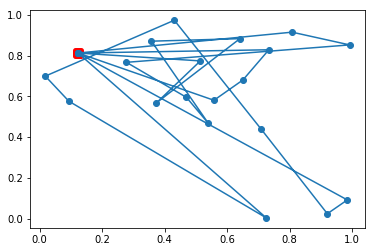

In [34]:
pi_np = [p.data[0].tolist() for p in pi]
x = [p[0] for p in pi_np]
y = [p[1] for p in pi_np]
plt.plot(x, y, "-o")
plt.scatter(x[0], y[0], c = "r", marker = "s", linewidths = 5)